In [8]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict


Matplotlib is building the font cache; this may take a moment.


In [9]:
class Neuron:
    def __init__(self, threshold=1.0, reset_potential=0.0, refractory_period=5):
        self.phi = np.random.rand()  # Phase between 0 and 1
        self.threshold = threshold
        self.reset_potential = reset_potential
        self.refractory_period = refractory_period
        self.refractory_timer = 0

    def update_phase(self, increment):
        self.phi += increment
        if self.phi >= 1.0:
            self.phi = 0
            return True  # Neuron fires
        return False

In [10]:
def create_neuron_network(network):
    for node in network.nodes:
        network.nodes[node]['neuron'] = Neuron()
    return network


In [11]:
def simulate_network(network, epsilon, max_steps=1000):
    firing_times = []
    for step in range(max_steps):
        # Find the neuron with the maximum phase
        max_phi_node = max(network.nodes, key=lambda n: network.nodes[n]['neuron'].phi)
        max_phi = network.nodes[max_phi_node]['neuron'].phi

        # Advance time
        time_increment = 1.0 - max_phi
        for node in network.nodes:
            neuron = network.nodes[node]['neuron']
            if neuron.update_phase(time_increment):
                firing_times.append((step, node))
                # Increase the activation of neighbors
                for neighbor in network.neighbors(node):
                    network.nodes[neighbor]['neuron'].phi += epsilon

        # Reset firing neurons
        network.nodes[max_phi_node]['neuron'].phi = 0

    return firing_times


In [12]:
def calculate_synchronization(network):
    phases = np.array([network.nodes[node]['neuron'].phi for node in network.nodes])
    return np.abs(np.mean(np.exp(2j * np.pi * phases)))


In [13]:
def measure_activity(firing_times, network_size):
    cascade_sizes = defaultdict(int)
    for time, neuron_id in firing_times:
        cascade_sizes[time] += 1
    average_cascade_size = np.mean(list(cascade_sizes.values()))
    return average_cascade_size


In [14]:
def run_simulations():
    network_sizes = [500, 1000, 1500]
    epsilon_values = [0.01, 0.05, 0.1]
    max_steps = 1000
    results = []

    for size in network_sizes:
        er_network = create_neuron_network(nx.erdos_renyi_graph(size, p=0.01))
        sf_network = create_neuron_network(nx.barabasi_albert_graph(size, m=5))
        sw_network = create_neuron_network(nx.watts_strogatz_graph(size, k=10, p=0.1))

        for epsilon in epsilon_values:
            for net_type, network in [('Erdos-Renyi', er_network), ('Scale-Free', sf_network), ('Small-World', sw_network)]:
                firing_times = simulate_network(network, epsilon, max_steps)
                avg_cascade_size = measure_activity(firing_times, size)
                sync_level = calculate_synchronization(network)
                results.append({
                    'Network Type': net_type,
                    'Network Size': size,
                    'Epsilon': epsilon,
                    'Average Cascade Size': avg_cascade_size,
                    'Synchronization Level': sync_level
                })
                print(f"{net_type} Network, Size: {size}, Epsilon: {epsilon}")
                print(f"Avg. Cascade Size: {avg_cascade_size}, Synchronization Level: {sync_level}")

    return results

results = run_simulations()


Erdos-Renyi Network, Size: 500, Epsilon: 0.01
Avg. Cascade Size: 1.025, Synchronization Level: 0.011224078827388722
Scale-Free Network, Size: 500, Epsilon: 0.01
Avg. Cascade Size: 1.056, Synchronization Level: 0.03173608799741968
Small-World Network, Size: 500, Epsilon: 0.01
Avg. Cascade Size: 1.057, Synchronization Level: 0.02528092937663329
Erdos-Renyi Network, Size: 500, Epsilon: 0.05
Avg. Cascade Size: 1.127, Synchronization Level: 0.023351035415196474
Scale-Free Network, Size: 500, Epsilon: 0.05
Avg. Cascade Size: 1.432, Synchronization Level: 0.07051521857022262
Small-World Network, Size: 500, Epsilon: 0.05
Avg. Cascade Size: 1.313, Synchronization Level: 0.0537395555691426
Erdos-Renyi Network, Size: 500, Epsilon: 0.1
Avg. Cascade Size: 1.262, Synchronization Level: 0.019561269618334567
Scale-Free Network, Size: 500, Epsilon: 0.1
Avg. Cascade Size: 2.424, Synchronization Level: 0.053104335040935965
Small-World Network, Size: 500, Epsilon: 0.1
Avg. Cascade Size: 1.688, Synchroniza

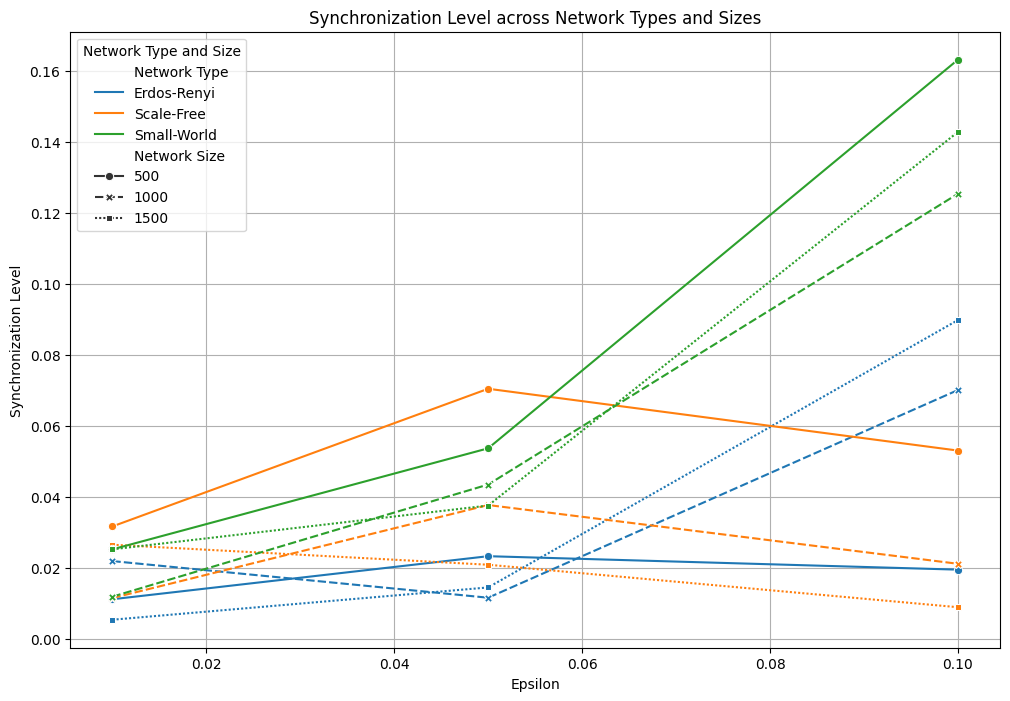

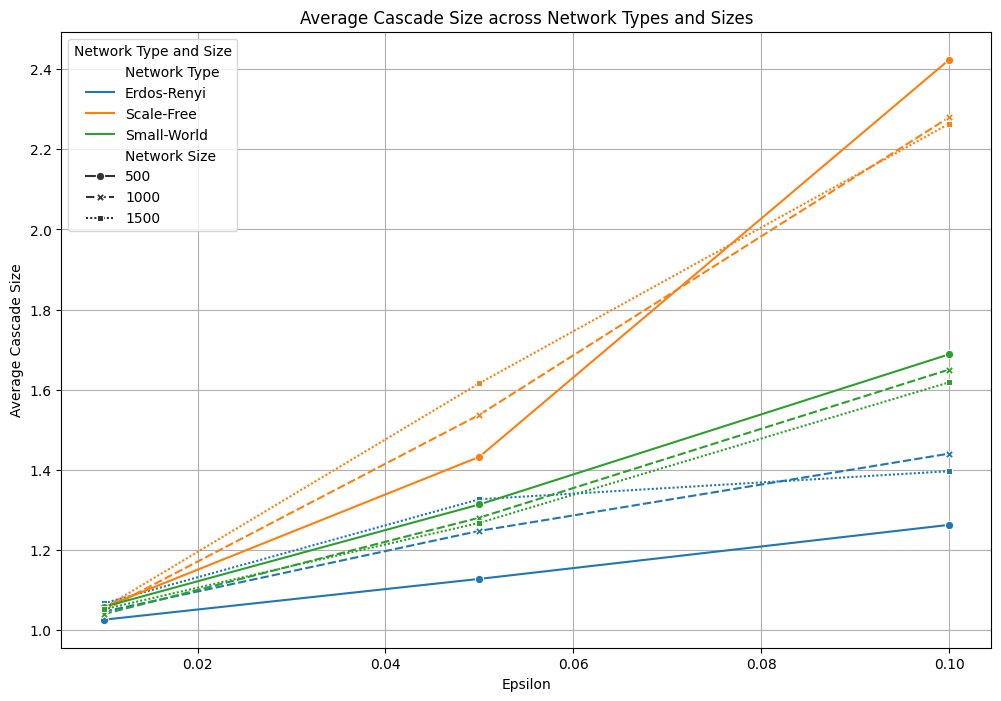

In [15]:
# Analysis and Visualization
results_df = pd.DataFrame(results)

# Plot synchronization level
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Epsilon', y='Synchronization Level', hue='Network Type', style='Network Size', markers=True)
plt.title('Synchronization Level across Network Types and Sizes')
plt.xlabel('Epsilon')
plt.ylabel('Synchronization Level')
plt.legend(title='Network Type and Size')
plt.grid(True)
plt.show()

# Plot average cascade size
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='Epsilon', y='Average Cascade Size', hue='Network Type', style='Network Size', markers=True)
plt.title('Average Cascade Size across Network Types and Sizes')
plt.xlabel('Epsilon')
plt.ylabel('Average Cascade Size')
plt.legend(title='Network Type and Size')
plt.grid(True)
plt.show()


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict, deque
from tqdm import tqdm
from joblib import Parallel, delayed

class BasicNeuron:
    def __init__(self, threshold=1.0, reset_potential=0.0, refractory_period=5, epsilon=1e-9):
        self.epsilon = epsilon
        self.phi = np.random.rand()  # Phase between 0 and 1
        self.x = -np.log(1 - self.phi + epsilon)  # Avoiding log(0)
        self.threshold = threshold
        self.reset_potential = reset_potential
        self.refractory_period = refractory_period
        self.refractory_timer = 0
        self.fired = False

    def update_phase(self, increment):
        if self.refractory_timer > 0:
            self.refractory_timer -= 1
            return False
        self.phi += increment
        if self.phi >= 1.0:
            self.phi = 0
            self.refractory_timer = self.refractory_period
            return True  # Neuron fires
        return False

    def reset(self):
        self.phi = 0
        self.x = 0
        self.fired = False

class AdExNeuron(BasicNeuron):
    def __init__(self, threshold=1.0, adaptation=0.1, **kwargs):
        super().__init__(threshold, **kwargs)
        self.adaptation = adaptation
        self.adaptive_threshold = threshold

    def adapt(self):
        self.adaptive_threshold += self.adaptation

    def reset(self):
        super().reset()
        self.adaptive_threshold = self.threshold

def create_neuron_network(graph, neuron_type='Basic', **kwargs):
    neuron_network = graph.copy()
    neuron_class = BasicNeuron if neuron_type == 'Basic' else AdExNeuron
    for node in neuron_network.nodes:
        neuron_network.nodes[node]['neuron'] = neuron_class(**kwargs)
    return neuron_network

def calculate_synchronization_level(network):
    phases = np.array([network.nodes[node]['neuron'].phi for node in network.nodes])
    complex_phases = np.exp(1j * phases * 2 * np.pi)
    r = np.abs(np.mean(complex_phases))
    return r

def reset_network(network):
    for node in network.nodes:
        network.nodes[node]['neuron'].reset()

def simulate_integrate_and_fire(network, epsilon, max_steps=100, neuron_type='Basic'):
    firing_times = []
    cascade_sizes = []
    neurons = nx.get_node_attributes(network, 'neuron')
    nodes = list(network.nodes)

    for step in tqdm(range(max_steps), desc=f"Simulating {neuron_type} network"):
        max_phi_node = max(nodes, key=lambda n: neurons[n].phi)
        max_phi_value = neurons[max_phi_node].phi
        time_increment = 1 - max_phi_value

        for neuron in neurons.values():
            neuron.phi += time_increment
            neuron.x = -np.log(1 - neuron.phi + neuron.epsilon)  # Avoiding log(0) by adding epsilon

        cascade_size = 0
        firing_queue = deque([max_phi_node])

        while firing_queue:
            firing_node = firing_queue.popleft()
            if not neurons[firing_node].fired:
                neurons[firing_node].fired = True
                if neuron_type == 'AdEx':
                    neurons[firing_node].adapt()
                neurons[firing_node].reset()
                cascade_size += 1
                for neighbor in network.neighbors(firing_node):
                    if not neurons[neighbor].fired:  # Avoid adding already fired neurons
                        neurons[neighbor].x += epsilon
                        if neurons[neighbor].x >= neurons[neighbor].threshold:
                            firing_queue.append(neighbor)

        for neuron in neurons.values():
            neuron.fired = False

        firing_times.append(time_increment)
        cascade_sizes.append(cascade_size)

        if step % 10 == 0:  # Debug print every 10 steps
            print(f"Step {step}: Time increment {time_increment}, Cascade size {cascade_size}")

    return firing_times, cascade_sizes

def run_simulation_for_params(neuron_type, network_type, network, size, epsilon):
    print(f"Starting simulation for {neuron_type} neurons in {network_type} network with size {size} and epsilon {epsilon}")
    firing_times, cascade_sizes = simulate_integrate_and_fire(network, epsilon, max_steps=500, neuron_type=neuron_type)
    avg_cascade_size = np.mean(cascade_sizes)
    sync_level = calculate_synchronization_level(network)

    result = {
        "Neuron Type": neuron_type,
        "Network Type": network_type,
        "Network Size": size,
        "Epsilon": epsilon,
        "Avg. Cascade Size": avg_cascade_size,
        "Synchronization Level": sync_level
    }

    print(f"Completed simulation: Neuron Type: {neuron_type}, Network Type: {network_type}, Size: {size}, Epsilon: {epsilon}, "
          f"Avg. Cascade Size: {avg_cascade_size}, Synchronization Level: {sync_level}")

    reset_network(network)
    return result

def run_simulations():
    network_sizes = [500, 1000, 1500]
    epsilon_values = [0.01, 0.05, 0.1, 0.15]
    neuron_types = ['Basic', 'AdEx']
    results = []

    for size in network_sizes:
        er_network = create_neuron_network(nx.erdos_renyi_graph(size, p=0.01))
        sf_network = create_neuron_network(nx.barabasi_albert_graph(size, m=5))
        sw_network = create_neuron_network(nx.watts_strogatz_graph(size, k=10, p=0.1))
        rr_network = create_neuron_network(nx.random_regular_graph(d=10, n=size))
        complete_network = create_neuron_network(nx.complete_graph(size))

        networks = {
            "Erdos-Renyi": er_network,
            "Scale-Free": sf_network,
            "Small-World": sw_network,
            "Random-Regular": rr_network,
            "Complete": complete_network
        }

        for neuron_type in neuron_types:
            for epsilon in epsilon_values:
                results.extend(Parallel(n_jobs=-1)(
                    delayed(run_simulation_for_params)(neuron_type, network_type, network, size, epsilon)
                    for network_type, network in networks.items()
                ))

                print(f"Completed simulations for neuron type {neuron_type}, network size {size}, and epsilon {epsilon}")

    return results

# Run simulations and save results
results = run_simulations()
results_df = pd.DataFrame(results)
results_df.to_csv("integrate_and_fire_optimized_results.csv", index=False)

# Plotting results
def plot_results(results_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 14))

    for neuron_type in results_df['Neuron Type'].unique():
        for network_type in results_df['Network Type'].unique():
            for size in results_df['Network Size'].unique():
                subset = results_df[(results_df['Neuron Type'] == neuron_type) &
                                    (results_df['Network Type'] == network_type) &
                                    (results_df['Network Size'] == size)]
                axs[0].plot(subset['Epsilon'], subset['Avg. Cascade Size'], label=f"{neuron_type}, {network_type}, Size {size}")
                axs[1].plot(subset['Epsilon'], subset['Synchronization Level'], label=f"{neuron_type}, {network_type}, Size {size}")

    axs[0].set_title('Average Cascade Size across Neuron Types, Network Types, and Sizes')
    axs[0].set_xlabel('Epsilon')
    axs[0].set_ylabel('Average Cascade Size')
    axs[0].legend()

    axs[1].set_title('Synchronization Level across Neuron Types, Network Types, and Sizes')
    axs[1].set_xlabel('Epsilon')
    axs[1].set_ylabel('Synchronization Level')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

results_df = pd.read_csv("integrate_and_fire_optimized_results.csv")
plot_results(results_df)


Starting simulation for Basic neurons in Small-World network with size 500 and epsilon 0.01
Starting simulation for Basic neurons in Random-Regular network with size 500 and epsilon 0.01
Starting simulation for Basic neurons in Scale-Free network with size 500 and epsilon 0.01
Starting simulation for Basic neurons in Erdos-Renyi network with size 500 and epsilon 0.01
Starting simulation for Basic neurons in Complete network with size 500 and epsilon 0.01


Simulating Basic network:   0%|          | 0/500 [02:50<?, ?it/s]

Simulating Basic network:   0%|          | 0/500 [02:50<?, ?it/s]


Step 0: Time increment 9.935809004990581e-06, Cascade size 219
Step 10: Time increment 0.0033278932452994736, Cascade size 1
Step 20: Time increment 0.0010358313911971173, Cascade size 1
Step 30: Time increment 0.014626807922145435, Cascade size 5
Step 40: Time increment 0.026070407879694835, Cascade size 2
Step 50: Time increment 0.011934496449734433, Cascade size 16
Step 60: Time increment 0.017073013206997056, Cascade size 1
Step 70: Time increment 0.2572176922231997, Cascade size 107
Step 80: Time increment 0.05520516401601516, Cascade size 1
Step 90: Time increment 0.0, Cascade size 2
Step 100: Time increment 0.0, Cascade size 12
Step 110: Time increment 0.5454124150757764, Cascade size 2000
Step 120: Time increment 0.0, Cascade size 1
Step 130: Time increment 0.0, Cascade size 12
Step 140: Time increment 0.5454124150757764, Cascade size 2000
Step 150: Time increment 0.0, Cascade size 1
Step 160: Time increment 0.0, Cascade size 12
Step 170: Time increment 0.5454124150757764, Casc

KeyboardInterrupt: 